### Import required libraries and necessary packages

In [22]:
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
import time


import keras
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import img_to_array,load_img
from keras.applications import VGG16
from keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.utils import np_utils, to_categorical
from sklearn.datasets import load_files
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix

### Load The data

In [23]:
#The path of our data on drive
data_dir =  r'E:\coviddataset1\COVID-19_Dataset\dataset'
 
#Loading Data
data = load_files(data_dir)

In [24]:
folders=os.listdir("E:\coviddataset1\COVID-19_Dataset\dataset")
print(folders)

['covid_images', 'normal_images', 'viral_images']


In [25]:
#Convert the data and labels to Numpy arrays
X = np.array(data['filenames'])
y = np.array(data['target'])
labels = np.array(data['target_names'])
 
# How the arrays look like?
print('Data files - ',X[0])
print('Target labels - ',y[0])
print('Number of training files : ', X.shape[0])
print('Number of training targets : ', y.shape[0])

Data files -  E:\coviddataset1\COVID-19_Dataset\dataset\normal_images\Normal-5551.png
Target labels -  1
Number of training files :  12315
Number of training targets :  12315


In [26]:
def convert_img_to_arr(file_path_list):
    arr = []
    img_width, img_height = 100,100 
    for file_path in file_path_list:
        img = load_img(file_path, target_size = (img_width, img_height))
        img = img_to_array(img)
        arr.append(img)
    return arr
# Here our data is updated and it's stocked in the X array
X = np.array(convert_img_to_arr(X))
print(X.shape) 
print('First training item : ',X[0])

(12315, 100, 100, 3)
First training item :  [[[104. 104. 104.]
  [ 74.  74.  74.]
  [ 58.  58.  58.]
  ...
  [142. 142. 142.]
  [150. 150. 150.]
  [159. 159. 159.]]

 [[  0.   0.   0.]
  [  0.   0.   0.]
  [  0.   0.   0.]
  ...
  [ 74.  74.  74.]
  [ 82.  82.  82.]
  [100. 100. 100.]]

 [[  0.   0.   0.]
  [  0.   0.   0.]
  [  0.   0.   0.]
  ...
  [  0.   0.   0.]
  [  0.   0.   0.]
  [  0.   0.   0.]]

 ...

 [[  2.   2.   2.]
  [  1.   1.   1.]
  [  0.   0.   0.]
  ...
  [  0.   0.   0.]
  [  1.   1.   1.]
  [  3.   3.   3.]]

 [[  2.   2.   2.]
  [  2.   2.   2.]
  [  0.   0.   0.]
  ...
  [  0.   0.   0.]
  [  1.   1.   1.]
  [  3.   3.   3.]]

 [[  2.   2.   2.]
  [  2.   2.   2.]
  [  0.   0.   0.]
  ...
  [  0.   0.   0.]
  [  1.   1.   1.]
  [  3.   3.   3.]]]


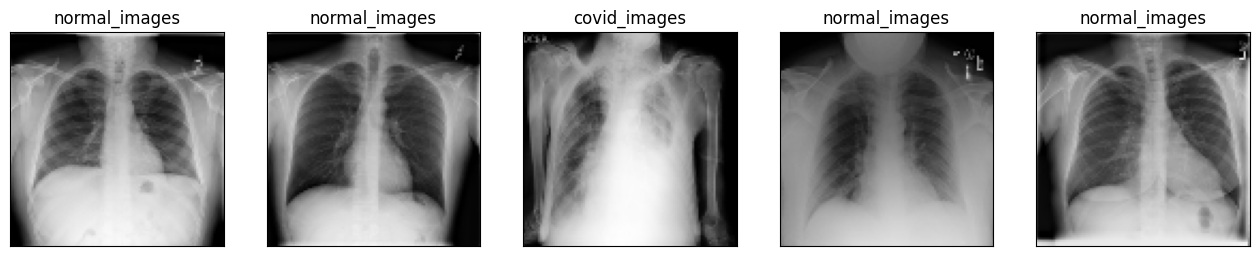

In [7]:
# Let's look at first 5 training data. 
fig = plt.figure(figsize = (16,9))
for i in range(5):
    ax = fig.add_subplot(1,5,i+1,xticks=[],yticks=[])
    ax.imshow((X[i].astype(np.uint8)))
    plt.title(folders[y[i]])

In [27]:
"""
   After that data is converted into Numpy array, Now, 
   Let's scale the pixel intenties to the range[0,255]
"""
X = X.astype('float32')/255

# Let's confirm the number of classes :) 
no_of_classes = len(np.unique(y))
no_of_classes

3

In [28]:
y

array([1, 1, 0, ..., 1, 1, 0])

In [29]:
""" 
let's converts a class vector (integers) to binary class matrix by performing the 
one-hot encoding on the labels
"""
y = np.array(np_utils.to_categorical(y,no_of_classes))
y[0]

array([0., 1., 0.], dtype=float32)

In [30]:
# let's splite the data into subsets and explore their shapes !

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
print('The train Data Shape ', X_train.shape[0])
 
X_test, X_valid, y_test, y_valid = train_test_split(X_test,y_test, test_size = 0.5)
print('The validation Data Shape ', X_valid.shape[0])
print('The test Data Shape ', X_test.shape[0])

The train Data Shape  9852
The validation Data Shape  1232
The test Data Shape  1231


In [31]:
print('The train Data Shape ', X_train.shape[1:])

The train Data Shape  (100, 100, 3)


### Fine tuning VGG16 pre-trained model


In [32]:
# load the VGG16 model without the final layers(include_top=False)
baseModel = VGG16(weights='imagenet', include_top=False, input_shape=X_train.shape[1:])
print("Base Model loaded !")
 
"""
  Loop over all layers in the base model and freeze them so they will
  not be updated during the first training process
"""
for layer in baseModel.layers:
    layer.trainable = False
    
baseModel.summary()

Base Model loaded !
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 2

### head Model
This Model we will put it later on the top of our base Model above. However, I will be using Sequential method as I am creating a sequential model. **Sequential model means that all the layers of the model will be arranged in sequence**, then i will add:
> - **AveragePooling2 layer of 4x4 pool size;**
- **Fully Connected :** 
>1. 1 x Flatten :
1. 1 x Dense of 64 units
1. 1 x Dropout  set at 50%
1. 1 x Dense of Softmax layer of 2 units
 
Few take aways :
>We are using **RELU** activation for the dense layer of 64 units so that I stop forwarding negative values through the network. I use a 2 unit dense layer in the end with softmax activation as I have 2 classes to predict from in the end which are **Covid-19** and **No-findings**. The softmax layer will output the value between 0 and 1 based on the confidence of the model that which class the images belongs to.
 
>**Dropout** is a technique of regularisation which helps us to prevent **overfitting**.

In [33]:
# In the summary above of our base model, trainable params is 0
""" Now, let's create a headModel to put on top of the base model
    (we are not freezing any layers of this model) 
"""
headModel = Sequential()
headModel.add(AveragePooling2D(pool_size=(3,3), input_shape=baseModel.output_shape[1:], name="AveragePooling2"))
headModel.add(Flatten( name ="Flatten"))
headModel.add(Dense(64, activation ="relu"))
headModel.add(Dropout(0.5, name="Dropout"))
headModel.add(Dense(no_of_classes, activation="softmax"))

headModel.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 AveragePooling2 (AveragePoo  (None, 1, 1, 512)        0         
 ling2D)                                                         
                                                                 
 Flatten (Flatten)           (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                32832     
                                                                 
 Dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 3)                 195       
                                                                 
Total params: 33,027
Trainable params: 33,027
Non-trainable params: 0
__________________________________________________

### Final Model
Here we are just going to put each model in its place, Yeah! We are talking about the base model (baseModel) and the head model (headModel). Therefor, we will put the first on the base and the second on the top. So, our final will look as showen below :

In [34]:
# In the summary above of our base model, trainable params is 32, 962
""" Let's build the final model where we add the top_model on top of base_model.
    So, we will place the head Model on the top of the base Model. Therefore, this 
    'Model' will become the actual model we will train
"""
Model = Sequential()
Model.add(baseModel)
Model.add(headModel)

Model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 sequential_2 (Sequential)   (None, 3)                 33027     
                                                                 
Total params: 14,747,715
Trainable params: 33,027
Non-trainable params: 14,714,688
_________________________________________________________________


### Compile the model
Here we will be using **Adam** optimiser to reach to the global minima while training our model. If I am stuck in local minima while training then the adam optimiser will help us to get out of local minima and reach global minima. We will also specify the learning rate of the optimiser, here in this case it is set at **1e-3 (0,001)**. If our training is bouncing a lot on epochs then we need to decrease the learning rate so that we can reach global minima.

In [35]:
lr = 1e-3
epochs = 50
bs = 8
optimizer = Adam(lr = lr, decay= lr/epochs)
Model.compile(optimizer, loss='binary_crossentropy', metrics=['accuracy'])

C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


---

### **Modelling**
>we are using **model.fit_generator** as we are using **ImageDataGenerator** to pass data to the model. I will pass **train** and **valid data** to **fit_generator**. In **fit_generator** **steps_per_epoch** will set the batch size to pass training data to the model and **validation_steps** will do the same for valid data. These settings could be changed according to each system specifications.
 
>For callbacks, we employed 
- **ModelCheckpoint :** Callback to save the model or model weights at certain frequencies. In this case, ModelCheckpoint helps us to save the model by monitoring a specific parameter of the model. In this case I am monitoring val_loss by passing save_best_only = True to ModelCheckpoint. The model will only be saved to disk if the val_loss of the model in current epoch is lower than what it was in the last epoch. So, our modewe will be saved on **CDX_Best.h5** file in the path specified below.

In [36]:

epochs = 8
 
# Initialize the training data augmentation object
train_datagen = ImageDataGenerator(
        rotation_range=15,
        fill_mode ="nearest")
 
checkpointer = ModelCheckpoint(filepath = "E:/COVID-19-Detection/Covid_vgg16.h5", save_best_only = True, verbose=1)
start = time.time()
 
history=Model.fit_generator(train_datagen.flow(X_train, y_train, batch_size = bs),
                            steps_per_epoch = len(X_train)//bs,
                            validation_data = (X_valid, y_valid),                     
                            epochs =epochs,
                            callbacks= [checkpointer])
 
end = time.time()
duration = end - start
print ('\n This Model took %0.2f seconds (%0.1f minutes) to train for %d epochs'%(duration, duration/60, epochs) )

C:\Users\HP\AppData\Local\Temp\ipykernel_3200\2430900214.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=Model.fit_generator(train_datagen.flow(X_train, y_train, batch_size = bs),


Epoch 1/8
1231/1231 [==============================] - ETA: 0s - loss: 0.3737 - accuracy: 0.7501
Epoch 1: val_loss improved from inf to 0.27452, saving model to E:/COVID-19-Detection\Covid_vgg16.h5
1231/1231 [==============================] - 2354s 2s/step - loss: 0.3737 - accuracy: 0.7501 - val_loss: 0.2745 - val_accuracy: 0.8157
Epoch 2/8
1231/1231 [==============================] - ETA: 0s - loss: 0.2855 - accuracy: 0.8203
Epoch 2: val_loss improved from 0.27452 to 0.25243, saving model to E:/COVID-19-Detection\Covid_vgg16.h5
1231/1231 [==============================] - 911s 741ms/step - loss: 0.2855 - accuracy: 0.8203 - val_loss: 0.2524 - val_accuracy: 0.8425
Epoch 3/8
1231/1231 [==============================] - ETA: 0s - loss: 0.2569 - accuracy: 0.8373
Epoch 3: val_loss improved from 0.25243 to 0.22975, saving model to E:/COVID-19-Detection\Covid_vgg16.h5
1231/1231 [==============================] - 2547s 2s/step - loss: 0.2569 - accuracy: 0.8373 - val_loss: 0.2297 - val_accuracy

**==> After training the model, we will be able to see the spectacular and the impressive performance reached ! :)**

---

### **Evaluation**


In [37]:
(eval_loss, eval_accuracy) = Model.evaluate(  
     X_test, y_test, batch_size=bs, verbose=2)
 
print("Accuracy: {:.2f}%".format(eval_accuracy * 100)) 
print("Loss: {}".format(eval_loss))

154/154 - 36s - loss: 0.2009 - accuracy: 0.8716 - 36s/epoch - 235ms/step
Accuracy: 87.16%
Loss: 0.20090679824352264


### Accuracy and Loss graphs

>Also, after training the model, we will be able to see spectacular and impressive clarifications! reached

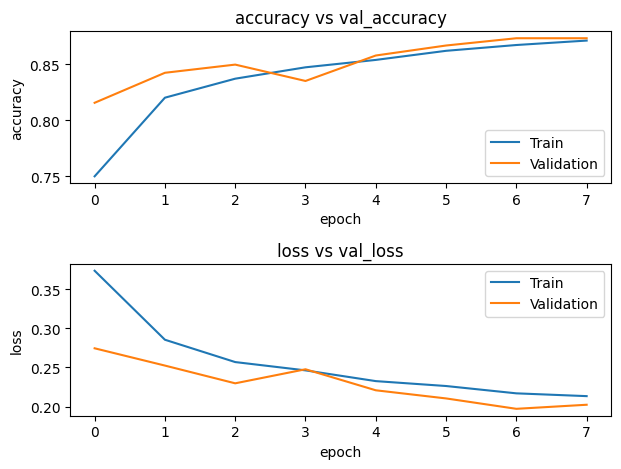

In [38]:
# Let's visualize the train/validation loss and accuracy wrt epochs
 
import matplotlib.pyplot as plt 
def plot(history):
    plt.figure(1) 
     # Summarize history for accuracy  
 
    plt.subplot(211)  
    plt.plot(history.history['accuracy'])  
    plt.plot(history.history['val_accuracy'])  
    plt.title('accuracy vs val_accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('epoch')  
    plt.legend(['Train', 'Validation'], loc='lower right')  
 
     # Summarize history for loss  
 
    plt.subplot(212)  
    plt.plot(history.history['loss'])  
    plt.plot(history.history['val_loss'])  
    plt.title('loss vs val_loss')  
    plt.ylabel('loss')  
    plt.xlabel('epoch')  
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.tight_layout()
    plt.show()
 
# Finaly, let's call the plot function with the 'result' parameter 
 
plot(history)

**Few take aways :**
- From the Training and Validation Accuracy graph above, our model does not seem to be overfitted, which is great!;
- Our Training and Validation Loss graph above also indicates a good learning rate, which is amazing !

---

### **Prediction**
>Finally, let us test our model against more random samples from the test data !

39/39 [==============================] - 34s 865ms/step


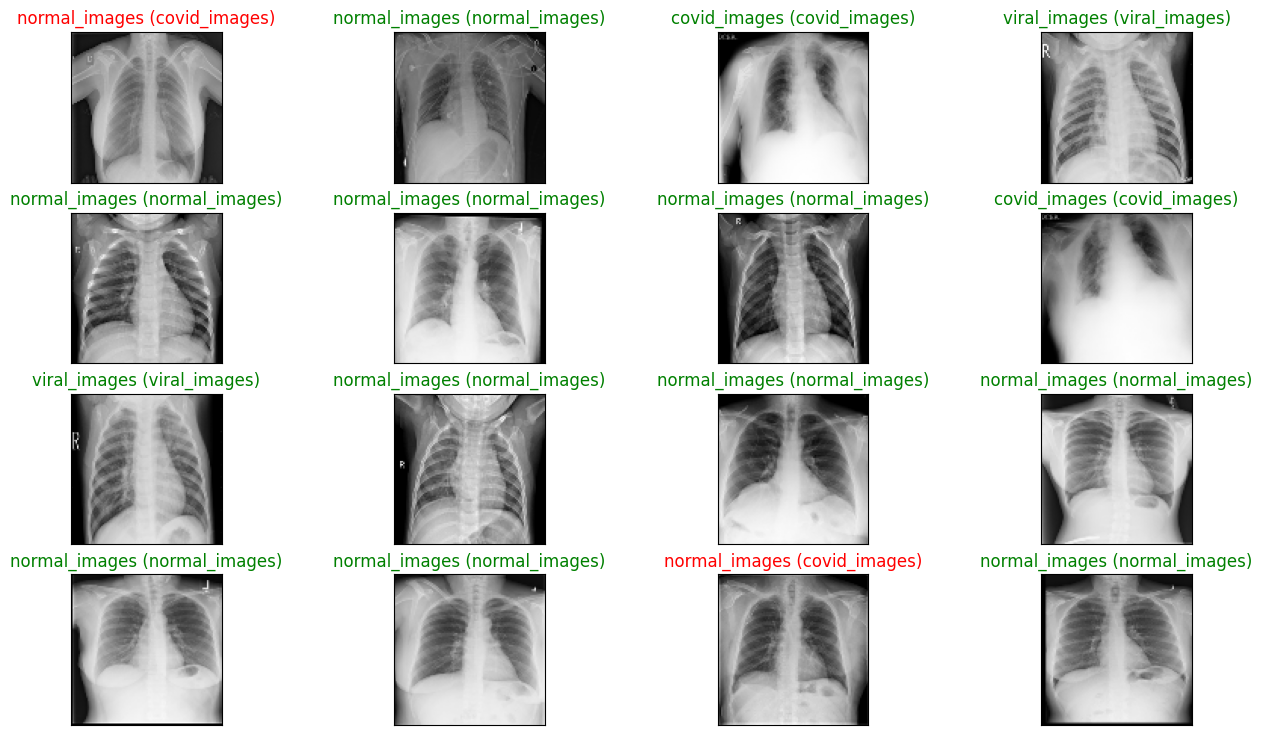

In [39]:
# Let's visualize some random test prediction.
def visualize_pred(y_pred):
# Plot a random sample of test images, their predicted labels, and ground truth
    fig = plt.figure(figsize=(16, 9))
    for i, idx in enumerate(np.random.choice(X_test.shape[0], size=16, replace=False)):
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(X_test[idx]))
        pred_idx = np.argmax(y_pred[idx])
        true_idx = np.argmax(y_test[idx])
        ax.set_title("{} ({})".format(labels[pred_idx], labels[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))
 
visualize_pred(Model.predict(X_test))

### Confusion Matrix
> Please note that, **_0_ and _1_ values represent _Covid-19_ and _No_findigs_ respectively**  .

39/39 [==============================] - 41s 1s/step


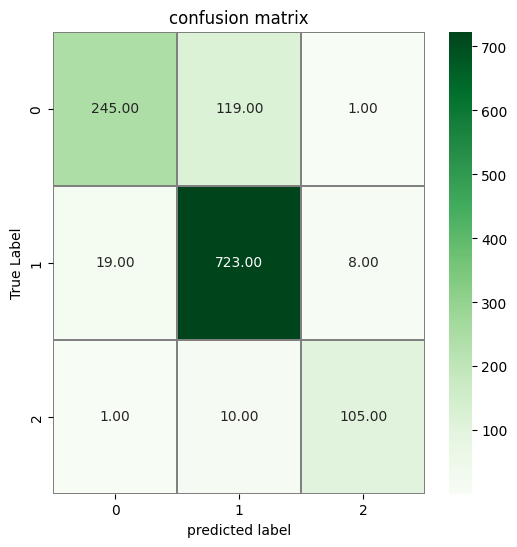

In [40]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

Y_pred = Model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1)
Y_true = np.argmax(y_test,axis = 1)
confusion_mtx = confusion_matrix(Y_true,Y_pred_classes)
f,ax = plt.subplots(figsize = (6,6))
sns.heatmap(confusion_mtx,annot=True,linewidths = 0.01,cmap="Greens",
            linecolor = "gray",fmt = ".2f",ax=ax
            )
plt.xlabel("predicted label")
plt.ylabel("True Label")
plt.title("confusion matrix")
plt.show()

**Few Take aways:**
- The easiest to detect is **Covid-19**, i.e. if you are infected then you are really infected
- It is clear that the model can sometimes deceive in stating that a person is not infected but it could be. Anyways, we need the expertise to explain this kind of stuff, especially when it comes to medicine. **Just we must not forget that we do not have enough images for Covid-19**.

- Our confusion matrix indicates that there are disturbing errors. which is Great!.

> You can check the classification report below for more information !

In [41]:
print(classification_report(y_test.argmax(axis=1),Y_pred_classes,  target_names= labels))

               precision    recall  f1-score   support

 covid_images       0.92      0.67      0.78       365
normal_images       0.85      0.96      0.90       750
 viral_images       0.92      0.91      0.91       116

     accuracy                           0.87      1231
    macro avg       0.90      0.85      0.86      1231
 weighted avg       0.88      0.87      0.87      1231



### Loading the model
> Here we're gonna load our best model trained befor, then make some predictions with it !

In [42]:
my_model=keras.models.load_model('E:/COVID-19-Detection/Covid_vgg16.h5')

39/39 [==============================] - 33s 834ms/step


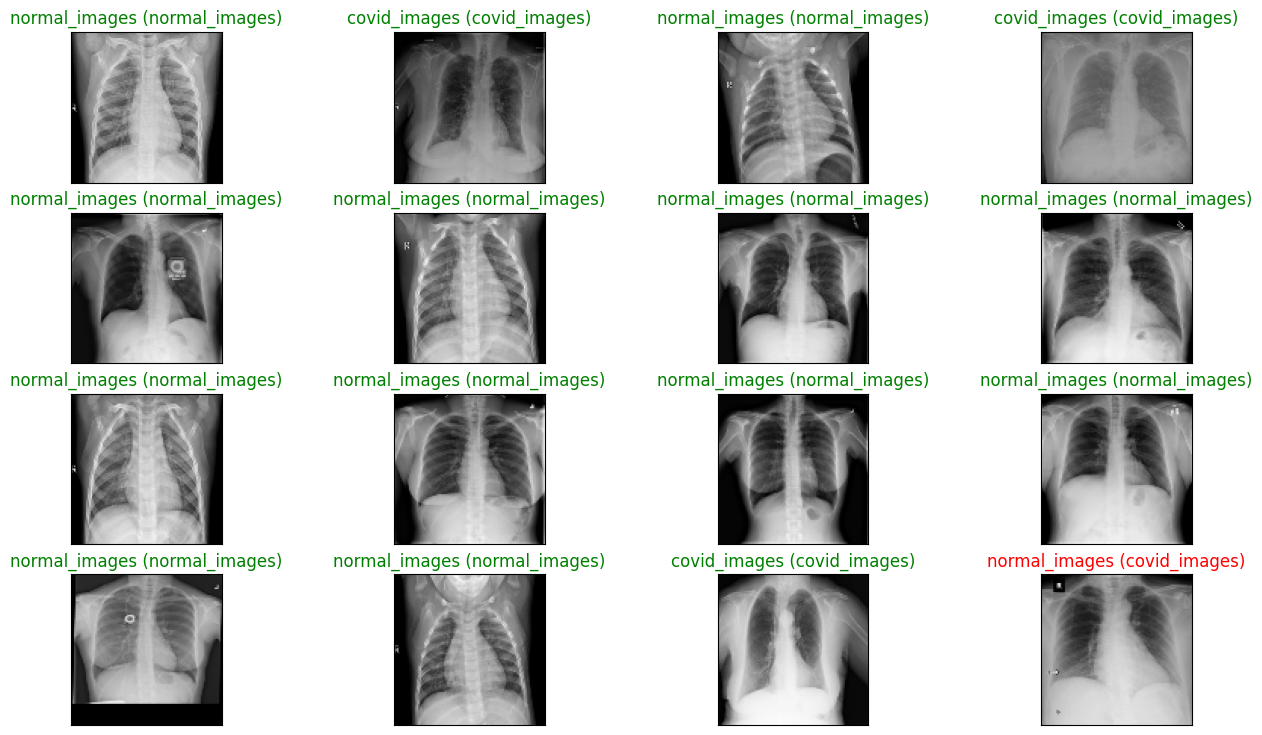

In [43]:
# Let's visualize some random test prediction.
def visualize_pred(y_pred):
# plot a random sample of test images, their predicted labels, and ground truth
    fig = plt.figure(figsize=(16, 9))
    for i, idx in enumerate(np.random.choice(X_test.shape[0], size=16, replace=False)):
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(X_test[idx]))
        pred_idx = np.argmax(y_pred[idx])
        true_idx = np.argmax(y_test[idx])
        ax.set_title("{} ({})".format(labels[pred_idx], labels[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))

visualize_pred(my_model.predict(X_test))

**======> These are great results :)** 

## **Conclusion**
The classification precision achieved is great! at all levels
>This project can be considered quite successful, and it's ready to be deployed.

## **Thank you a lot for your interest** ☻